In [2]:
import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *


In [3]:

# Generate data 
N = 180
lvl = gen_states( lvls=[0,1], ch=20, n=N)
o = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, 3, N)  
#other_data = {"o": o, "model": rw1, "state":lvl}

model = rw1_att
other_data = {"o": o, "model": model, "state":lvl}
rewards = model([50, 0.2], other_data)


# Fit data 
bnds = ((0,100),(0,1))
#bnds = ((0,100),(0,1),(0,1))
opt = minimize(fun=lklhd, x0=[50, 0.5], args=(rewards["Q"],other_data), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})
print(opt.message)
print(opt.x)

# Look inside the model 
M = lklhd_m(opt.x, rewards["Q"],other_data)

f,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(rewards["Q"])
m1 = model(opt.x, other_data)
ax.plot(m1["Q"])

/tmp/ipykernel_478670/672250352.py:15: OptimizeWarning: Unknown solver options: verbose
  opt = minimize(fun=lklhd, x0=[50, 0.5], args=(rewards["Q"],other_data), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})


KeyboardInterrupt: 

In [ ]:
M["HQC"]

2824.199000410238

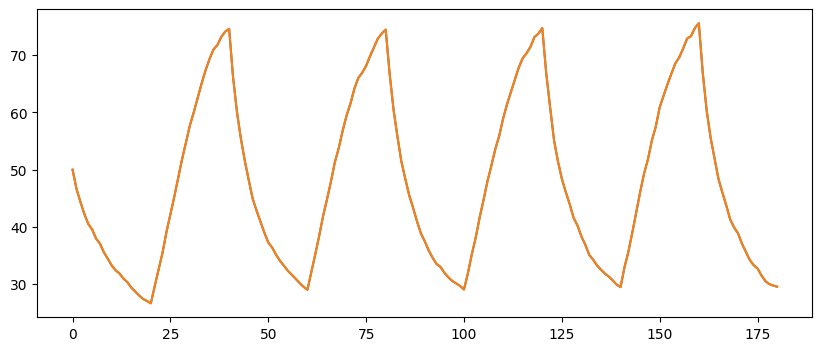

In [ ]:
f,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(rewards["Q"])
m1 = model(opt.x, other_data)
ax.plot(m1["Q"])

## Noise levels

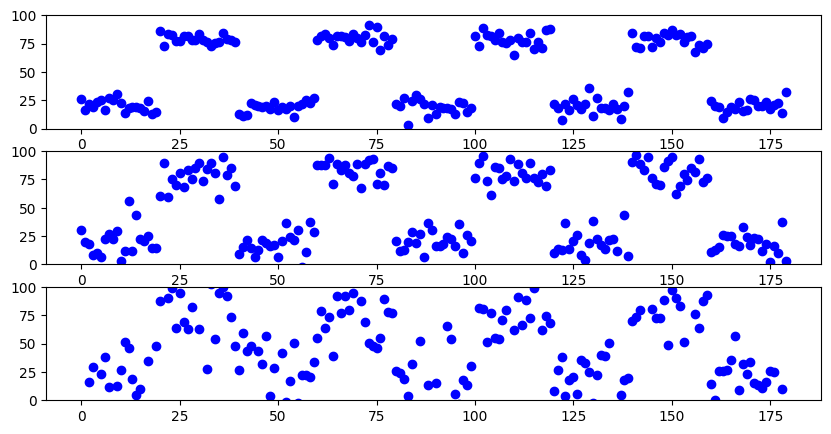

In [ ]:
f, ax = plt.subplots(3,1, figsize=(10,5))
for i_idx, unc in enumerate([5, 10, 20]):
    o = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, unc, N) 
    ax[i_idx].plot(o, 'bo')
    ax[i_idx].set_ylim([0,100])

 

In [ ]:
# The changes etc were too predictable 

### Do the actual procedure

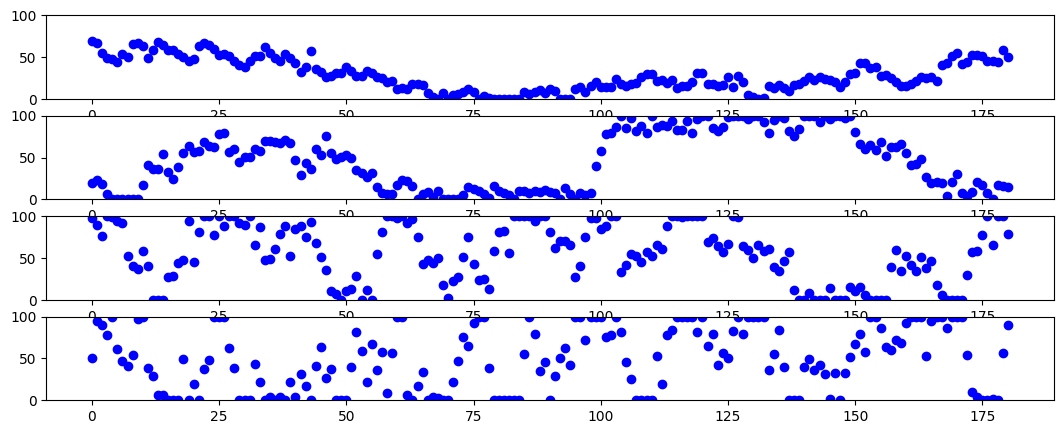

In [31]:
import random
def gaus_walk(N=180, vol = 5, noise=noise):
    r = np.array([np.random.random()*100])
    for i in range(N):
        x  = np.random.normal(r[i], vol, 1) + np.random.normal(0, noise, 1)     
        if x > 100:
            x = 100
        elif x<0: 
            x=0
        r = np.append(r, x) 
    return r

f, ax = plt.subplots(4,1, figsize=(13,5))
for i_idx, unc in enumerate([5, 10, 20, 40]):
    r = gaus_walk(N=180, vol = 5, noise=unc)
    #gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, unc, N) 
    ax[i_idx].plot(r, 'bo')
    ax[i_idx].set_ylim([0,100])



In [ ]:
len([0
     ])

1

In [35]:
import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *

cond = "test"
alg = "Nelder-Mead"
noise = 10
value_noise=10
vol=5
rand_rew = 0.2
c = 60
iterations = 2
cond_str = "mc_n"+str(noise)+"_c"+str(c)+"_i"+str(iterations)+"_"+alg


N = 180
#noise_level= [5, 10, 20]
#cutoff = [90, 120, 150]
models = [rw1, rw1_att, rw2_val, ph_basic] 
model_names = ["rw1", "rw1_att", "rw2_val", "ph_basic"]
bounds = {"rw1": ((0,100),(0,1)),
          "rw1_att": ((0,100),(0,1)), 
          "rw2_val": ((0,100),(0,1),(0,1)),
          "ph_basic": ((0,100),(0,1),(0,1))}
df = pd.DataFrame()


for ii in range(iterations):
    print(np.round(ii/iterations,2))
    # Generate data
    r_all = gaus_walk(N=180, vol = vol, noise=noise)
    #o_all = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, noise, N) 


    r_train = r_all[0:c]
    r_test = r_all[c:]

    for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
        params_in = gen_rand_vals(bounds[mname])
        full_pred = m(params_in, {"o": r_all, "model": m})

        # add noise to values
        full_pred["Q"] = full_pred["Q"] + np.random.normal(0, value_noise, N+2) 

        value_train = full_pred["Q"][0:c]
        value_test = full_pred["Q"][c:]
        
        # Fit data 
        AIC =[] 
        BIC = []
        AICc = [] 
        HQC = [] #https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion
        P = {}
        for mfit, mname_fit in zip(models, model_names):
            other_data = {"o": r_train, "model": mfit, "bounds": bounds, "alg":alg, "model_name":mname_fit}
            opt = minimize(fun=lklhd, x0=gen_rand_vals(bounds[mname_fit]), args=(value_train,other_data), method=alg, bounds=bounds[mname_fit], options={'verbose': 0})

            #cv_res = custom_CV(other_data)

            # Get IC 
            M = lklhd_m(opt.x, value_train, other_data)
            AIC.append(M["AIC"])
            P[mname_fit] = opt.x
            BIC.append(M["BIC"])
            AICc.append(M["AICc"])
            HQC.append(M["HQC"])
        
        # which model fit best
        best_idx =[np.argmin(AIC), np.argmin(AICc), np.argmin(BIC), np.argmin(HQC)]
        # is this the correct model
        #if aic_idx == m_idx:
        #    m_recovery_AIC = 1 # etc

        # get predictive error per trial of the best model
        pred_err = []
        for idxx, best in enumerate(best_idx):
            test_data = {"o": r_test, "model": models[best_idx[idxx]]}
            Mbest = lklhd_m(P[model_names[best_idx[idxx]]], value_test, test_data)
            pred_err.append(Mbest["err_per_n"])

        # Gather data
        D = {"noise": noise, "cutoff":c, "true_model": mname, "algo":alg,
            "best_model_AIC": model_names[best_idx[0]], 
            "best_model_AICc": model_names[best_idx[1]],  
            "best_model_BIC": model_names[best_idx[2]], 
            "best_model_HQC": model_names[best_idx[3]], 
            "mean_err_AIC": pred_err[0],
            "mean_err_AICc": pred_err[1],
            "mean_err_BIC": pred_err[2], 
            "mean_err_HQC": pred_err[3]                  
            }
        dfrow = pd.DataFrame.from_dict(D, orient="index").T
        df = pd.concat([df, dfrow], axis=0)
df.to_csv(os.path.join(rf, "data", cond, "model_comparison_iter"+cond_str+".csv") )

0.0


In [ ]:
for idxx, best in enumerate(best_idx):
    other_data = {"o": o_test, "model": models[best_idx[idxx]], "state":lvl_test}
    Mbest = lklhd_m(P[model_names[best_idx[idxx]]], rew_test, other_data)
    pred_err.append(Mbest["err_per_n"])

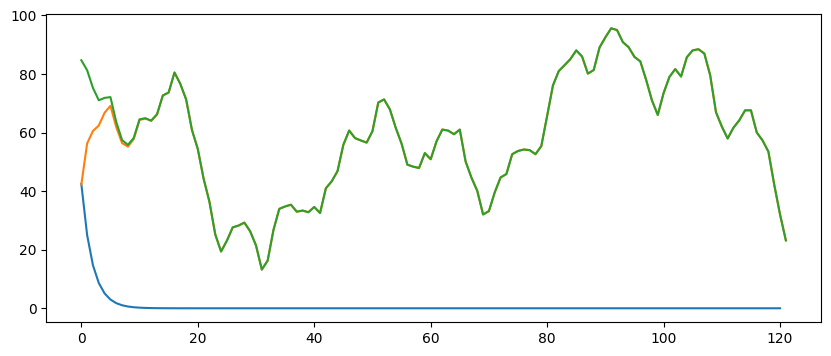

In [33]:
f,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(Mbest["err"])
ax.plot(Mbest["Q"])
ax.plot(value_test)
#Mbest["Q"]
#ax.scatter(Mbest["Q"], rew_test)